In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from scipy.special import digamma
import data, random

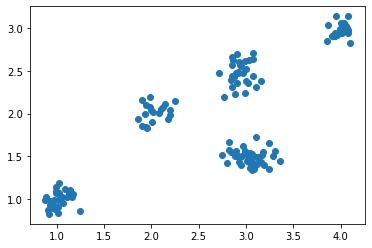

In [2]:
centers_x = [1, 2,   3,   3, 4]
centers_y = [1, 2, 1.5, 2.5, 3]
covs = [np.array([[1, 0],[0, 1]]), 
        np.array([[2, 0.3],[0.3, 1]]),
        np.array([[2, -0.3],[-0.3, 1]]),
        np.array([[1, 0.3],[0.3, 2]]), 
        np.array([[0.5, 0.1],[0.1, 0.5]])]
datanums = [30, 20, 40, 30, 20]

data = []

for i in range(5):
    p = multivariate_normal((centers_x[i], centers_y[i]), covs[i]/100)
    data.extend(p.rvs(datanums[i]))
    
random.shuffle(data)
#print(data)

plt.scatter([x for (x,y) in data], [y for (x,y) in data])
    


In [3]:
K = 10

def initial_r(data):
    rs = []
    for i,d in enumerate(data):
        r = [0]*K
        r[i%10] = 1.0
        
        rs.append(r)
        
    return rs

In [4]:
rs = initial_r(data)

In [5]:
def weighted_num(k, rs):
    return sum([r[k] for r in rs])

def weighted_mean(k, rs, data):
    return sum([ r[k]*p for (r, p) in zip(rs, data)])/weighted_num(k, rs)
    
def weighted_cov(k, rs, data):
    xbar = weighted_mean(k, rs, data)
    return sum([ r[k]*(p-xbar).reshape((2, 1)).dot((p-xbar).reshape((2, 1)).T) for (r, p) in zip(rs, data)])/weighted_num(k, rs)

In [6]:
ns = [weighted_num(k, rs) for k in range(K)]
xs = [weighted_mean(k, rs, data) for k in range(K)]
covs = [weighted_cov(k, rs, data) for k in range(K)]

In [7]:
print(ns)
print(xs)
print(covs)

[14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0]
[array([2.51045253, 1.84760031]), array([2.86168231, 2.09931085]), array([2.79387684, 1.9551742 ]), array([2.51646477, 1.82963891]), array([2.99556213, 2.18292519]), array([2.26777066, 1.57591542]), array([2.26026538, 1.62842344]), array([2.53308244, 1.90089362]), array([2.52200672, 1.94580928]), array([2.54221454, 1.85718822])]
[array([[0.94319524, 0.51220193],
       [0.51220193, 0.48848937]]), array([[0.82266098, 0.51261549],
       [0.51261549, 0.46315485]]), array([[0.81478418, 0.46140167],
       [0.46140167, 0.48103878]]), array([[0.96321609, 0.50300862],
       [0.50300862, 0.44020147]]), array([[0.59649222, 0.32093309],
       [0.32093309, 0.433202  ]]), array([[1.00070191, 0.45279685],
       [0.45279685, 0.39330515]]), array([[1.10560503, 0.4908114 ],
       [0.4908114 , 0.41733486]]), array([[1.07612107, 0.59579105],
       [0.59579105, 0.50800406]]), array([[0.93720793, 0.52251404],
       [0.52251404, 0.43114399

In [8]:
def update_params(org_alpha, org_beta, org_nu, org_m, org_w_inv, k, ns, xs, covs):
    alpha = org_alpha + ns[k]
    beta = org_beta + ns[k]
    nu = org_nu + ns[k]
    m = (org_beta * org_m + ns[k]*xs[k])/beta
    w_inv = org_w_inv + ns[k]*covs[k] + (org_beta*ns[k])/(org_beta + ns[k])*(xs[k] - org_m).reshape((2,1)).dot((xs[k] - org_m).reshape((2,1)).T)
    
    return (alpha, beta, nu, m, w_inv)

In [9]:
def rho(d, k, alphas, betas, nus, ms, w_invs):
    first = digamma(alphas[k]) - digamma(sum(alphas))
    second_2 = digamma((nus[k])/2) + digamma((nus[k] - 1)/2) + np.log(1/np.linalg.det(w_invs[k]))
    third_2 = 2/betas[k] + nus[k]*(d - ms[k]).reshape((2,1)).T.dot(np.linalg.inv(w_invs[k])).dot((d - ms[k]).reshape((2,1)))[0][0]
    
    log_rho = first + second_2/2 - third_2/2
    
    return np.exp(log_rho)

In [10]:
def calc_rs(alphas, betas, nus, ms, w_invs):
    rs = []
    for d in data:
        rhos = [ rho(d, k, alphas, betas, nus, ms, w_invs) for k in range(K)]
        sm = sum(rhos)
        rs.append(rhos/sm)
        
    return rs

In [11]:
alphas = [1]*K
betas = [1]*K
nus = [1]*K
ms = [np.array([0,0])]*K
w_invs = [np.array([[1, 0],[0, 1]])]*K

for k in range(K):
    params = update_params(1,1,1, np.array([0,0]), np.array([[1, 0],[0, 1]]), k, ns, xs, covs)
    alphas[k] = params[0]
    betas[k] = params[1]
    nus[k] = params[2]
    ms[k] = params[3]
    w_invs[k] = params[4]
    
print(alphas)
print(betas)
print(nus)
print(ms)
print(w_invs)

[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0]
[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0]
[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0]
[array([2.34308902, 1.72442695]), array([2.67090349, 1.9593568 ]), array([2.60761838, 1.82482925]), array([2.34870045, 1.70766299]), array([2.79585799, 2.03739685]), array([2.11658595, 1.47085439]), array([2.10958103, 1.51986188]), array([2.36421027, 1.77416738]), array([2.35387294, 1.81608866]), array([2.37273357, 1.73337567])]
[array([[20.08694708, 11.499919  ],
       [11.499919  , 11.02490295]]), array([[20.16053099, 12.78367358],
       [12.78367358, 11.59746685]]), array([[19.69234317, 11.55797154],
       [11.55797154, 11.30240194]]), array([[20.39544722, 11.33939449],
       [11.33939449, 10.28722725]]), array([[17.72605747, 10.59621208],
       [10.59621208, 11.51231288]]), array([[19.80975822,  9.67471628],
       [ 9.67471628,  8.82421419]]), array([[21.24668335, 10.30665084],
       [10.3066508